In [1]:
import pandas as pd

df = pd.read_csv("../data/cleaned/cleaned_brentoil_data.csv", parse_dates=['Date'], index_col='Date')
df.dropna(inplace=True)

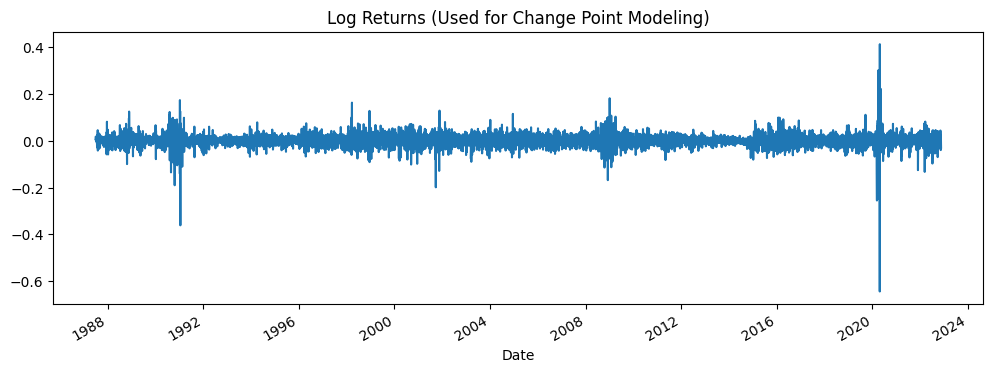

In [2]:
import matplotlib.pyplot as plt

df['log_return'].plot(figsize=(12, 4), title="Log Returns (Used for Change Point Modeling)")
plt.show()

In [3]:
import pymc as pm
import numpy as np
import arviz as az

# Limit dataset for faster sampling
returns = df['log_return'].dropna().iloc[:200].values
n = len(returns)
idx = np.arange(n)

with pm.Model() as model_cp:
    tau = pm.DiscreteUniform('tau', lower=0, upper=n)
    mu1 = pm.Normal('mu1', mu=0, sigma=0.05)
    mu2 = pm.Normal('mu2', mu=0, sigma=0.05)
    sigma = pm.HalfNormal('sigma', sigma=0.05)

    mu = pm.math.switch(tau >= idx, mu1, mu2)
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=returns)

    trace = pm.sample(1000, tune=500, target_accept=0.95, return_inferencedata=True)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma]


c:\PY\Change-point-analysis-and-statistical-modelling-of-time-series-data\venv\Lib\site-packages\rich\live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 641 seconds.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,132.050,70.058,7.000,200.000,16.161,8.272,25.0,127.0,1.12
mu1,-0.000,0.004,-0.006,0.009,0.001,0.001,112.0,118.0,1.06
mu2,0.005,0.018,-0.013,0.033,0.001,0.003,107.0,231.0,1.04
sigma,0.018,0.001,0.017,0.020,0.000,0.000,1036.0,1243.0,1.01


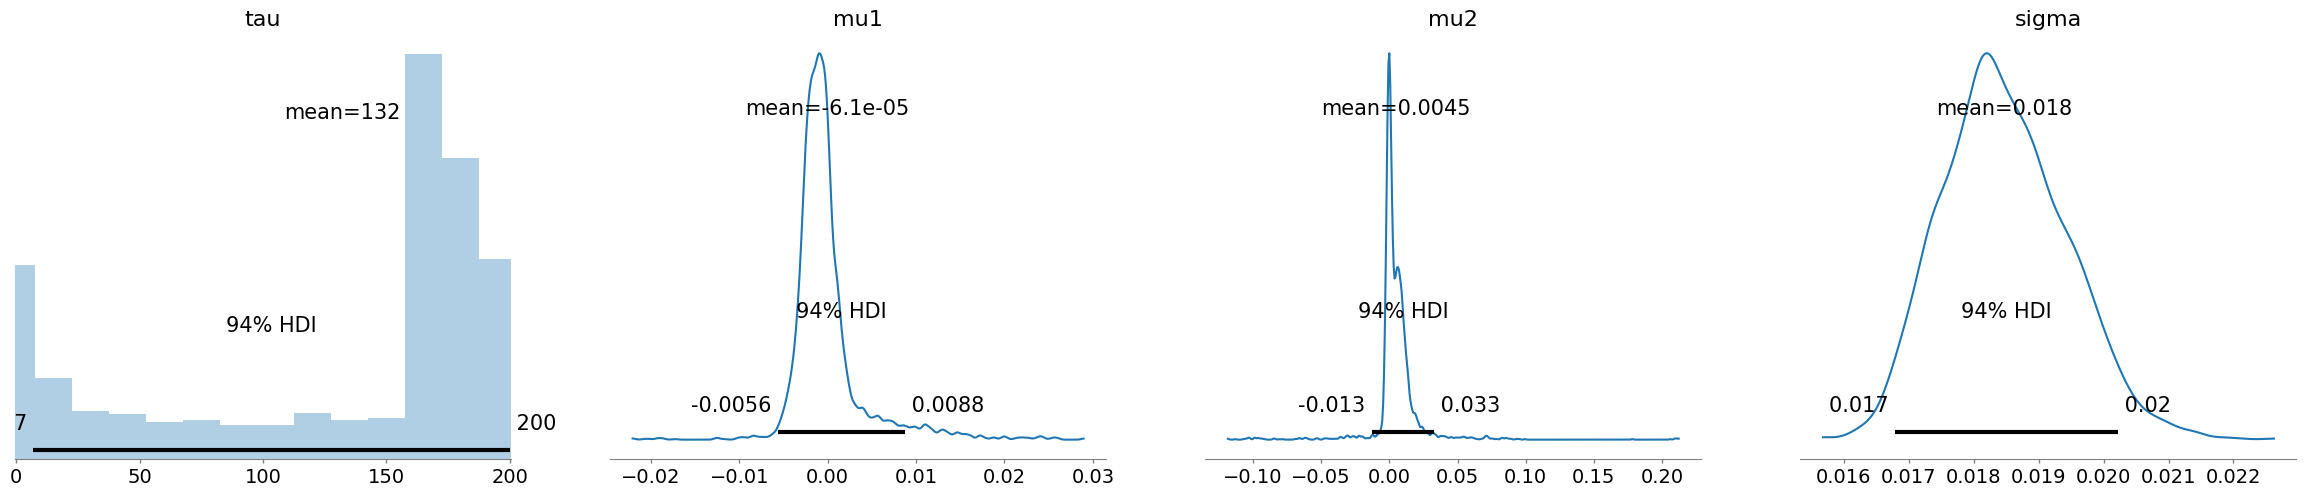

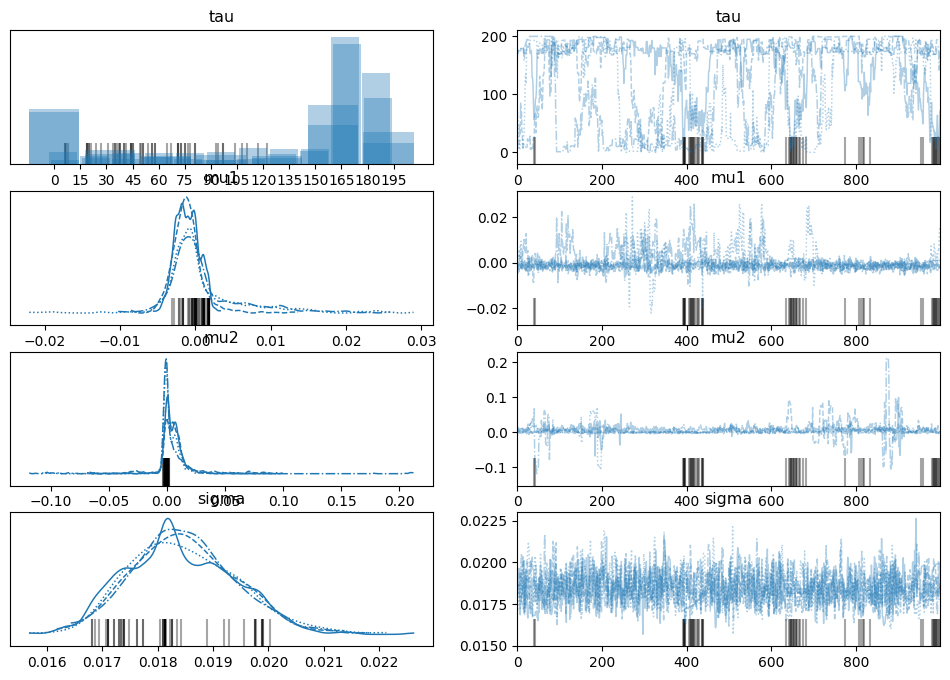

In [4]:
#convergence
import arviz as az

# Posterior plot
az.plot_posterior(trace, var_names=['tau', 'mu1', 'mu2', 'sigma'])

# Trace plot
az.plot_trace(trace, var_names=['tau', 'mu1', 'mu2', 'sigma'])

# Summary stats
az.summary(trace, var_names=['tau', 'mu1', 'mu2', 'sigma'])

In [5]:
#most probable change point 
tau_posterior = trace.posterior['tau'].values.flatten()
tau_mode = np.bincount(tau_posterior).argmax()
print(f"Most probable change point index: {tau_mode}")
print(f"Corresponding date: {df.index[tau_mode]}")


Most probable change point index: 200
Corresponding date: 1988-04-15 00:00:00


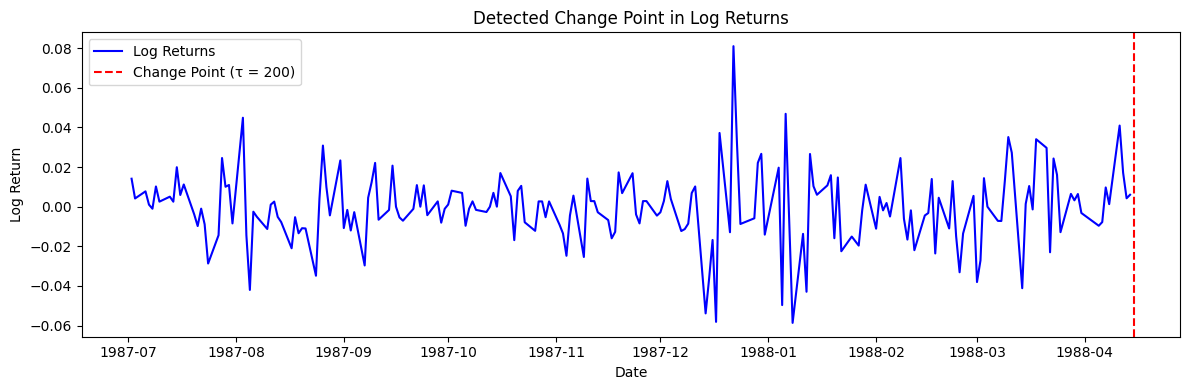

In [6]:
# Plot the log returns with change point
plt.figure(figsize=(12, 4))
plt.plot(df.index[:len(returns)], returns, label='Log Returns', color='blue')
plt.axvline(df.index[tau_mode], color='red', linestyle='--', label=f'Change Point (τ = {tau_mode})')
plt.title("Detected Change Point in Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
#Report the posterior means of mu1 and mu2
mu1_mean = trace.posterior['mu1'].mean().values
mu2_mean = trace.posterior['mu2'].mean().values

print(f"Mean before change: {mu1_mean:.5f}")
print(f"Mean after change: {mu2_mean:.5f}")
print(f"Percent Change: {(mu2_mean - mu1_mean)/abs(mu1_mean) * 100:.2f}%")


Mean before change: -0.00006
Mean after change: 0.00450
Percent Change: 7477.78%


In [8]:
import json
from pathlib import Path

# Prepare the results dictionary
result_dict = {
    "change_point_index": int(tau_mode),
    "change_point_date": str(df.index[tau_mode].date()),
    "mu1_mean": float(mu1_mean),
    "mu2_mean": float(mu2_mean),
    "percent_change": float((mu2_mean - mu1_mean)/abs(mu1_mean) * 100),
}

# add timeseries data for frontend plotting
result_dict["log_returns"] = [
    {"date": str(date.date()), "log_return": float(val)}
    for date, val in zip(df.index[:len(returns)], returns)
]

# Save the result
output_path = Path("../data/results/change_point_result.json")
output_path.parent.mkdir(parents=True, exist_ok=True)

with open(output_path, "w") as f:
    json.dump(result_dict, f, indent=4)

print(f"Saved result to: {output_path.resolve()}")


Saved result to: C:\PY\Change-point-analysis-and-statistical-modelling-of-time-series-data\data\results\change_point_result.json
